# *Set up*

In [103]:
!pip install ndjson
!pip install cairocffi
!pip install imutils

In [110]:
import os
import ndjson
import pandas as pd
import cairocffi as cairo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import imutils
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader

In [3]:
category = ['apple','face'] # add training classes
image_size = 28
number_per_catogory = 1000
dataset_seed = 42
train_ratio = 0.7
all_samples = len(category)*number_per_catogory

np.random.seed(dataset_seed)
TRAIN_INDICES = list(np.random.choice(all_samples, int(all_samples*train_ratio)))
VAL_INDICES = list(set(range(all_samples)) - set(TRAIN_INDICES))



In [5]:
# download simplified data
!mkdir quickDrawData
for item in category:
  path=os.path.join('gs://quickdraw_dataset/full/simplified',item+'.ndjson')
  print(path)
  !gsutil -m cp $path ./quickDrawData/

gs://quickdraw_dataset/full/simplified/apple.ndjson
Copying gs://quickdraw_dataset/full/simplified/apple.ndjson...
\ [1/1 files][ 56.1 MiB/ 56.1 MiB] 100% Done                                    
Operation completed over 1 objects/56.1 MiB.                                     
gs://quickdraw_dataset/full/simplified/face.ndjson
Copying gs://quickdraw_dataset/full/simplified/face.ndjson...
| [1/1 files][ 89.4 MiB/ 89.4 MiB] 100% Done                                    
Operation completed over 1 objects/89.4 MiB.                                     


# *Helper functions*

In [4]:
# credit to:
#https://github.com/googlecreativelab/quickdraw-dataset/issues/19

def vector_to_raster(vector_images, side=28, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

In [173]:
def rotate_img(img):
  angle = np.random.randint(20, 160)  # chosen uniformly between -20 and +20.
  # Determine the centre
  height, width = img.shape[:2]
  cX, cY = (width // 2, height // 2)
  # Get the rotation matrix 
  M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
  cos = np.abs(M[0, 0])
  sin = np.abs(M[0, 1])
  # Compute the new bounding dimensions of the image
  nW = int((height * sin) + (width * cos))
  nH = int((height * cos) + (width * sin))
  # Adjust the rotation matrix
  M[0, 2] += (nW / 2) - cX
  M[1, 2] += (nH / 2) - cY
  # Perform the actual rotation
  img = cv2.warpAffine(img, M, (nW, nH))
  new_height, new_width = img.shape[:2]
  new_cX, new_cY = (new_width // 2, new_height // 2)
  crop_img = img[new_cY-20:new_cY+20, new_cX-20:new_cX+20]
  return crop_img

In [93]:
def shear_img(img):
  shear_factor = np.random.randint(10, 20)
  shear_factor /= 100
  height, width = img.shape[:2]
  M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
  nW =  img.shape[1] + abs(shear_factor*img.shape[0])
  img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
  img = cv2.resize(img, (width,height))
  return img

# *DrawDataset*

In [176]:
class DrawDataset(data.Dataset):
    def __init__(self, train, image_size, categories, number_per_catogory, transformation=None):
        all_images = []
        all_labels = []
        all_keys = []
        for item in categories:
          with open(os.path.join('quickDrawData',item+'.ndjson')) as f:
            print(item)
            data = ndjson.load(f)
            df=pd.DataFrame.from_dict(data)
            new_df=df[df['countrycode']=='CA']
            new_df=new_df[new_df['recognized']==True]
            all_images+=(list(new_df['drawing'].values)[:number_per_catogory])
            all_labels+=(list(new_df['word'].values)[:number_per_catogory])
            all_keys+=(list(new_df['key_id'].values)[:number_per_catogory])

        arr=vector_to_raster(all_images,side=image_size)
        images = [x.reshape(image_size,image_size) for x in arr]

        all_labels=np.array(all_labels)
        images=np.array(images)
        all_keys=np.array(all_keys)


        if train==True:
          all_labels=all_labels[TRAIN_INDICES]
          images=images[TRAIN_INDICES]
          all_keys=all_keys[TRAIN_INDICES]
          images=[np.pad(x, [(6, 6), (6, 6)], mode='constant', constant_values=0) for x in images]
        else:
          # TO DO: ADD TRANSFORMATION FOR TEST SET according to the following link
          # https://www.cs.toronto.edu/~tijmen/affNIST/
          if transformation==None:
            all_labels=all_labels[VAL_INDICES]
            images=images[VAL_INDICES]
            all_keys=all_keys[VAL_INDICES]
            images=[np.pad(x, [(6, 6), (6, 6)], mode='constant', constant_values=0) for x in images]
          elif transformation=='rotate':
            all_labels=all_labels[VAL_INDICES]
            images=[np.pad(x, [(26, 26), (26, 26)], mode='constant', constant_values=0) for x in images[VAL_INDICES]]
            images = [rotate_img(img) for img in images]
            #images=list(map(rotate_img, images[VAL_INDICES]))
            all_keys=all_keys[VAL_INDICES]
          elif transformation=='shear':
            all_labels=all_labels[VAL_INDICES]
            images = [shear_img(img) for img in images[VAL_INDICES]]
            all_keys=all_keys[VAL_INDICES]
            images=[np.pad(x, [(6, 6), (6, 6)], mode='constant', constant_values=0) for x in images]

        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(all_labels)
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        
        self.X = images
        self.y = onehot_encoded
        self.labels = all_labels
        self.keys = all_keys
        # normalize

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index],self.y[index]

In [118]:
train_dataset=DrawDataset(True, image_size, category, number_per_catogory)
val_dataset=DrawDataset(False, image_size, category, number_per_catogory)

apple
face
apple
face


In [177]:
val_dataset_with_rotation=DrawDataset(False, image_size, category, number_per_catogory, transformation='rotate')
val_dataset_with_shearing=DrawDataset(False, image_size, category, number_per_catogory, transformation='shear')

apple
face
apple
face


# *Check the results (delete it later...)*

1007
1007


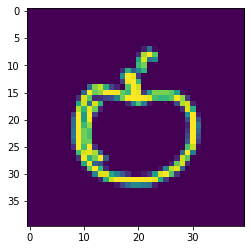

[1. 0.]
apple


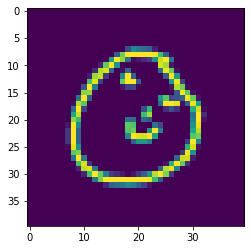

[0. 1.]
face


In [178]:
# Check without transformation--------
# total # of training examples
print(len(val_dataset))
print(len(val_dataset.labels))
# Apple
img1 = val_dataset[2][0]
plt.imshow(img1)
plt.show()
print(val_dataset[2][1])
print(val_dataset.labels[2])
# Face
img2 = val_dataset[1000][0]
plt.imshow(img2)
plt.show()
print(val_dataset[1000][1])
print(val_dataset.labels[1000])

1007
1007


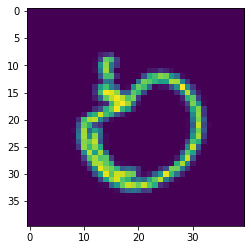

[1. 0.]
apple


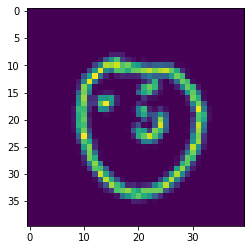

[0. 1.]
face


In [179]:
# Check with transformation--------
# total # of training examples
print(len(val_dataset_with_rotation))
print(len(val_dataset_with_rotation.labels))
# Apple
img1 = val_dataset_with_rotation[2][0]
plt.imshow(img1)
plt.show()
print(val_dataset_with_rotation[2][1])
print(val_dataset_with_rotation.labels[2])
# Face
img2 = val_dataset_with_rotation[1000][0]
plt.imshow(img2)
plt.show()
print(val_dataset_with_rotation[1000][1])
print(val_dataset_with_rotation.labels[1000])

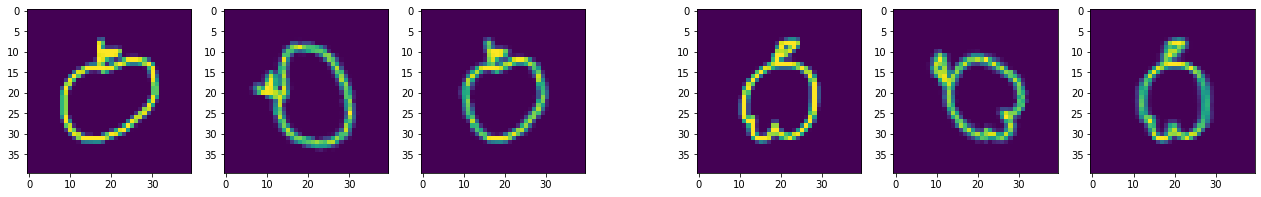

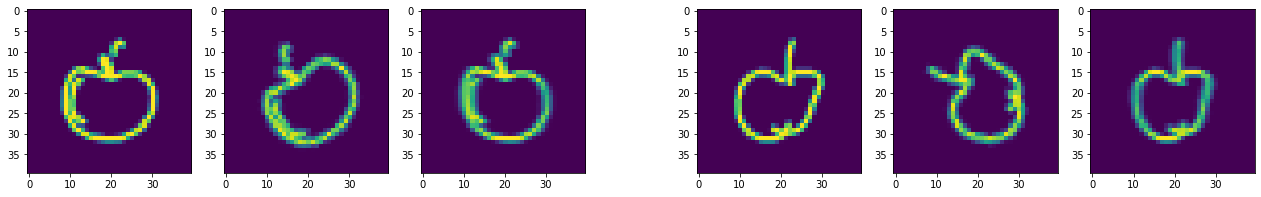

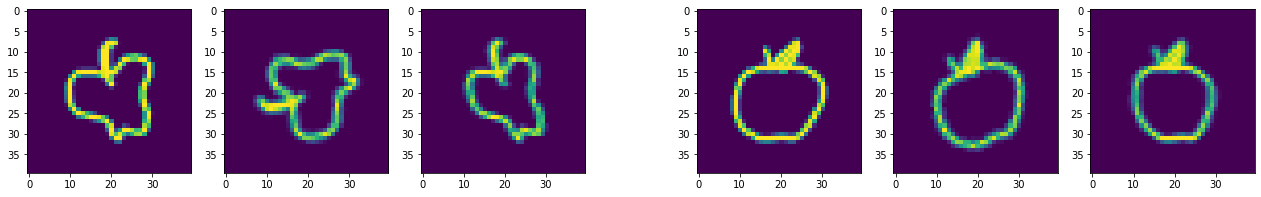

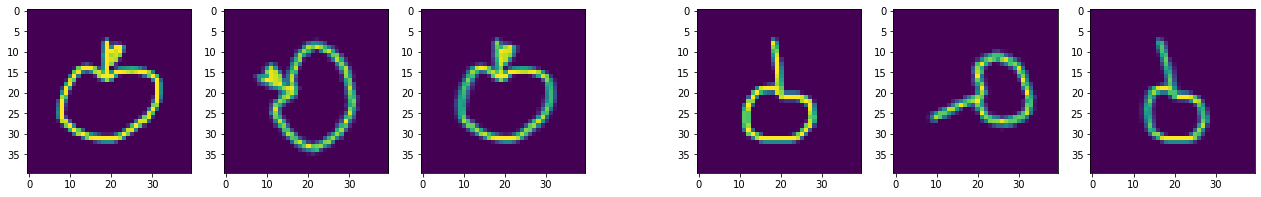

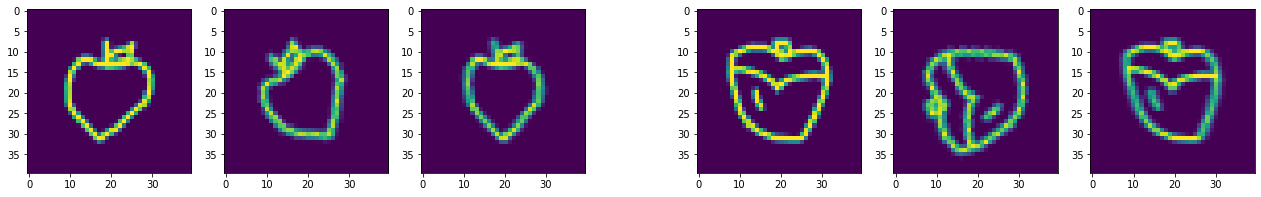

In [180]:
for i in range(0, 10, 2):
    fig = plt.figure()
    fig.set_figheight(22)
    fig.set_figwidth(22)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    gs0 = gridspec.GridSpec(1, 2)

    gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0], hspace=0)
    ax0 = fig.add_subplot(gs00[0])
    ax0.imshow(val_dataset[i][0])
    ax1 = fig.add_subplot(gs00[1], sharex=ax0)
    ax1.imshow(val_dataset_with_rotation[i][0])
    ax2 = fig.add_subplot(gs00[2], sharex=ax0)
    ax2.imshow(val_dataset_with_shearing[i][0])

    gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1], hspace=0)
    ax3 = fig.add_subplot(gs01[0])
    ax3.imshow(val_dataset[i+1][0])
    ax4 = fig.add_subplot(gs01[1], sharex=ax3)
    ax4.imshow(val_dataset_with_rotation[i+1][0])
    ax5 = fig.add_subplot(gs01[2], sharex=ax0)
    ax5.imshow(val_dataset_with_shearing[i+1][0])

# *DataLoader*

In [9]:
batch_size = 32
train_loader=DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=batch_size,shuffle=False)